# Stacking Images for Improved CLIP Generation

In [1]:
device = "cuda"

In [190]:
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning kornia

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm.notebook import tqdm
import kornia.augmentation as K

In [4]:
# #getting CLIP
# !git clone https://github.com/openai/CLIPfrom_pretrained

In [5]:
from CLIP import clip # The clip model
clip_model = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)

In [6]:
def get_text_embs(text):
    return clip_model.encode_text(clip.tokenize(text).to(device))

def get_image_embs(pt_image):
    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])
    return clip_model.encode_image(normalize(pt_image))

In [7]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
import imitools as I

Cloning into 'imitools'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 46 (delta 24), reused 16 (delta 6), pack-reused 0
Unpacking objects: 100% (46/46), 419.09 KiB | 1.44 MiB/s, done.


## BaseLine

Trying to generate an image with CLIP

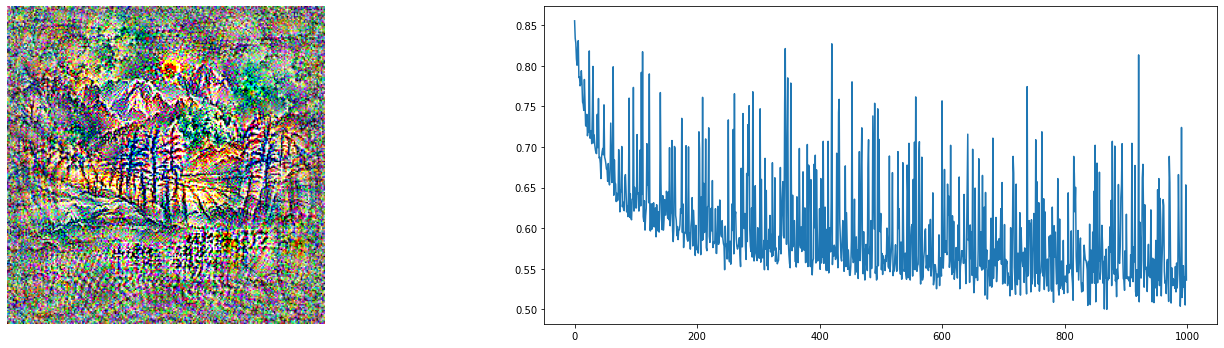

  0%|          | 0/1000 [00:00<?, ?it/s]

In [215]:
prompt = "A watercolor landscape with the sun over mountains covered in trees"
steps = 1000

apply_transformations = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

def calc_loss(a, b):
    return 1.0 - torch.nn.CosineSimilarity()(a, b)

# # Let's use a different tool
# # here lower values has a better match
# def calc_loss(im_embed, text_embed):
#     im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
#     text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
#     dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
#     return dists.mean()

text_embs = get_text_embs(prompt)
im = torch.rand(1, 3, 224, 224).to(device)
im.requires_grad_()
optimizer = torch.optim.SGD([im], lr=100)

lp = I.live_plot(2)
losses = []
    
for step in tqdm(range(steps)):
    optimizer.zero_grad()
    
    image_embs = get_image_embs(apply_transformations(im.clip(0, 1)))
    
    loss = calc_loss(image_embs, text_embs)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if step % 50 == 0 or step == steps-1:
        lp.imshow(0, im.clip(0, 1))
        lp.plot(1, losses)
        lp.update()
    
lp.close()

## Stacking Images

In [18]:
im_smaller = torch.rand(1, 3, 8, 8)

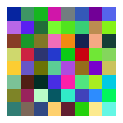

In [16]:
I.wrap(im_smaller).show(scale=2)

torch.Size([1, 3, 64, 64])


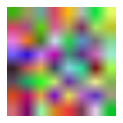

In [19]:
scale_it = torch.nn.Upsample(scale_factor=8, mode="bilinear", align_corners=False)
im_scaled = scale_it(im_smaller)
print(im_scaled.shape)
I.wrap(im_scaled).show(scale=2)

**Okay. It works. Now let's make the ImStack class.**

In [240]:
class ImStack:
    def __init__(self, size=224, n_layers=4, decay=0.7, device="cpu"):
        self.size = size
        self.n_layers = n_layers
        self.layers = []
        for i in range(n_layers):
            im_width = size//(2 ** i)
            scale_factor = decay ** (n_layers - i)
            self.layers.append(torch.randn(1, 3, im_width, im_width, device=device) * scale_factor)
        
        self.upscalers = [torch.nn.Upsample(scale_factor=pow(2, i), mode="bilinear", align_corners=False) for i in range(n_layers)]
        
        for l in self.layers: l.requires_grad = True
        
    def get_merged(self):
        scaled = [self.upscalers[i](self.layers[i]) for i in range(self.n_layers)]
        merged = torch.cat(scaled, dim=0).sum(dim=0)
        return torch.sigmoid(merged).unsqueeze(0)
    
    def get_layer_images(self):
        return [I.wrap(torch.sigmoid(self.layers[i])).pil() for i in range(self.n_layers)]

In [171]:
ims = ImStack(device=device)

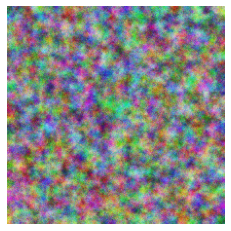

In [172]:
I.wrap(ims.get_merged()).show()

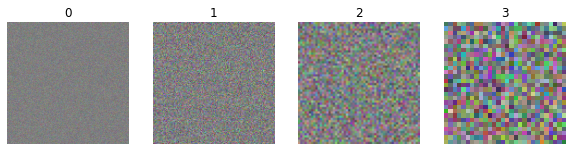

In [173]:
I.wrap(ims.get_layer_images()).show()

## Let's use ImWrap inside Loop

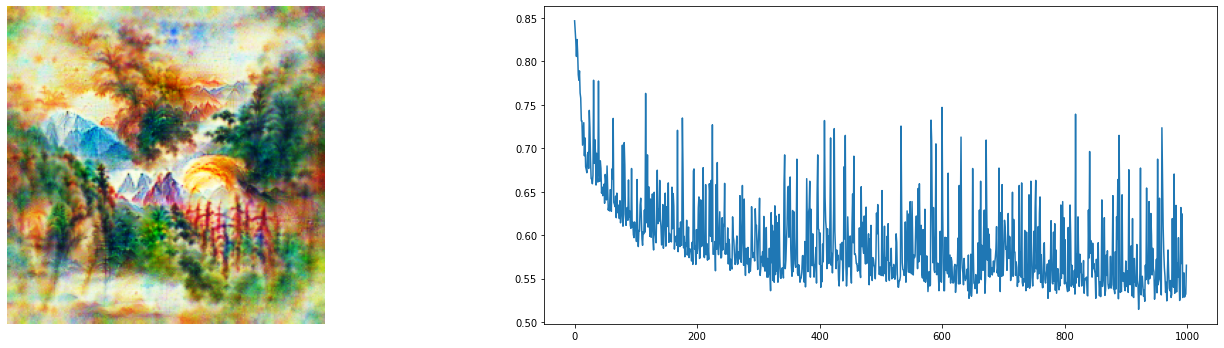

  0%|          | 0/1000 [00:00<?, ?it/s]

In [243]:
torch.manual_seed(43)
prompt = "A watercolor landscape with the sun over mountains covered in trees"
steps = 1000

apply_transformations = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

def calc_loss(a, b):
    return 1.0 - torch.nn.CosineSimilarity()(a, b)

# # Let's use a different tool
# # here lower values has a better match
# def calc_loss(im_embed, text_embed):
#     im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
#     text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
#     dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
#     return dists.mean()

text_embs = get_text_embs(prompt)
the_image = ImStack(device=device, n_layers=5, size=224)
optimizer = torch.optim.SGD(the_image.layers, lr=100)

lp = I.live_plot(2)
losses = []
    
for step in tqdm(range(steps)):
    optimizer.zero_grad()
    
    gen_image = the_image.get_merged()
    
    image_embs = get_image_embs(apply_transformations(gen_image))
    
    loss = calc_loss(image_embs, text_embs)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if step % 50 == 0 or step == steps-1:
        lp.imshow(0, gen_image)
        lp.plot(1, losses)
        lp.update()
    
lp.close()

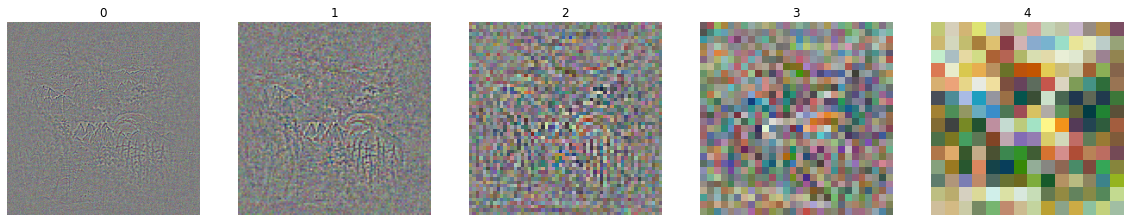

In [244]:
I.wrap(the_image.get_layer_images()).show(scale=4)